In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
from scipy import stats

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import os


In [11]:
train = pd.read_csv('/Users/ancysharmila/Desktop/Python/train.csv')
test = pd.read_csv('/Users/ancysharmila/Desktop/Python/test.csv')

In [12]:
train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


Clean and Transform Dataset

Based on the training data above, there are several things we need to do in order to prepare the data for use in a model. There are several catagorical variables that need to be encoded, including our target variable 'Satisfaction'. There are also a couple of columns that are unnecessary, such as 'Unnamed:0' and 'id'. We can drop these. The functions below will be used to perform the dataset preparation.

In [13]:
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customer_type(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
    
def transform_travel_type(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1
    
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1
    
def process_data(df):
    df = df.drop(['Unnamed: 0', 'id'], axis = 1)
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace = True)
    
    return df

train = process_data(train)
test = process_data(test)

In [14]:
train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,1,13,0,1,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,0
1,0,0,25,1,2,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,0
2,1,1,26,1,2,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,1
3,1,1,25,1,2,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,0
4,0,1,61,1,2,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,1


In [15]:
#Define our features and target (this is helpful in case you would like to drop any features that harm model performance)
features = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
target = ['satisfaction']

# Split into test and train
X_train = train[features]
y_train = train[target].to_numpy()
X_test = test[features]
y_test = test[target].to_numpy()

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Normalization Complete! 
Also, just for kicks, lets take a look at a correlation heatmap to see which features correlate well with customer satisfaction.

Best features - Online Booking, Class, and Type of Travel
Worst features - Gate location, Gender, and Departure/Arrival Time Convenient
We will keep all of our features in for now, but can always return to this step in case we want to drop features.

/var/folders/49/2shrnk3d6bz46y53gpyp8dkm0000gn/T/ipykernel_9203/2911005644.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot: >

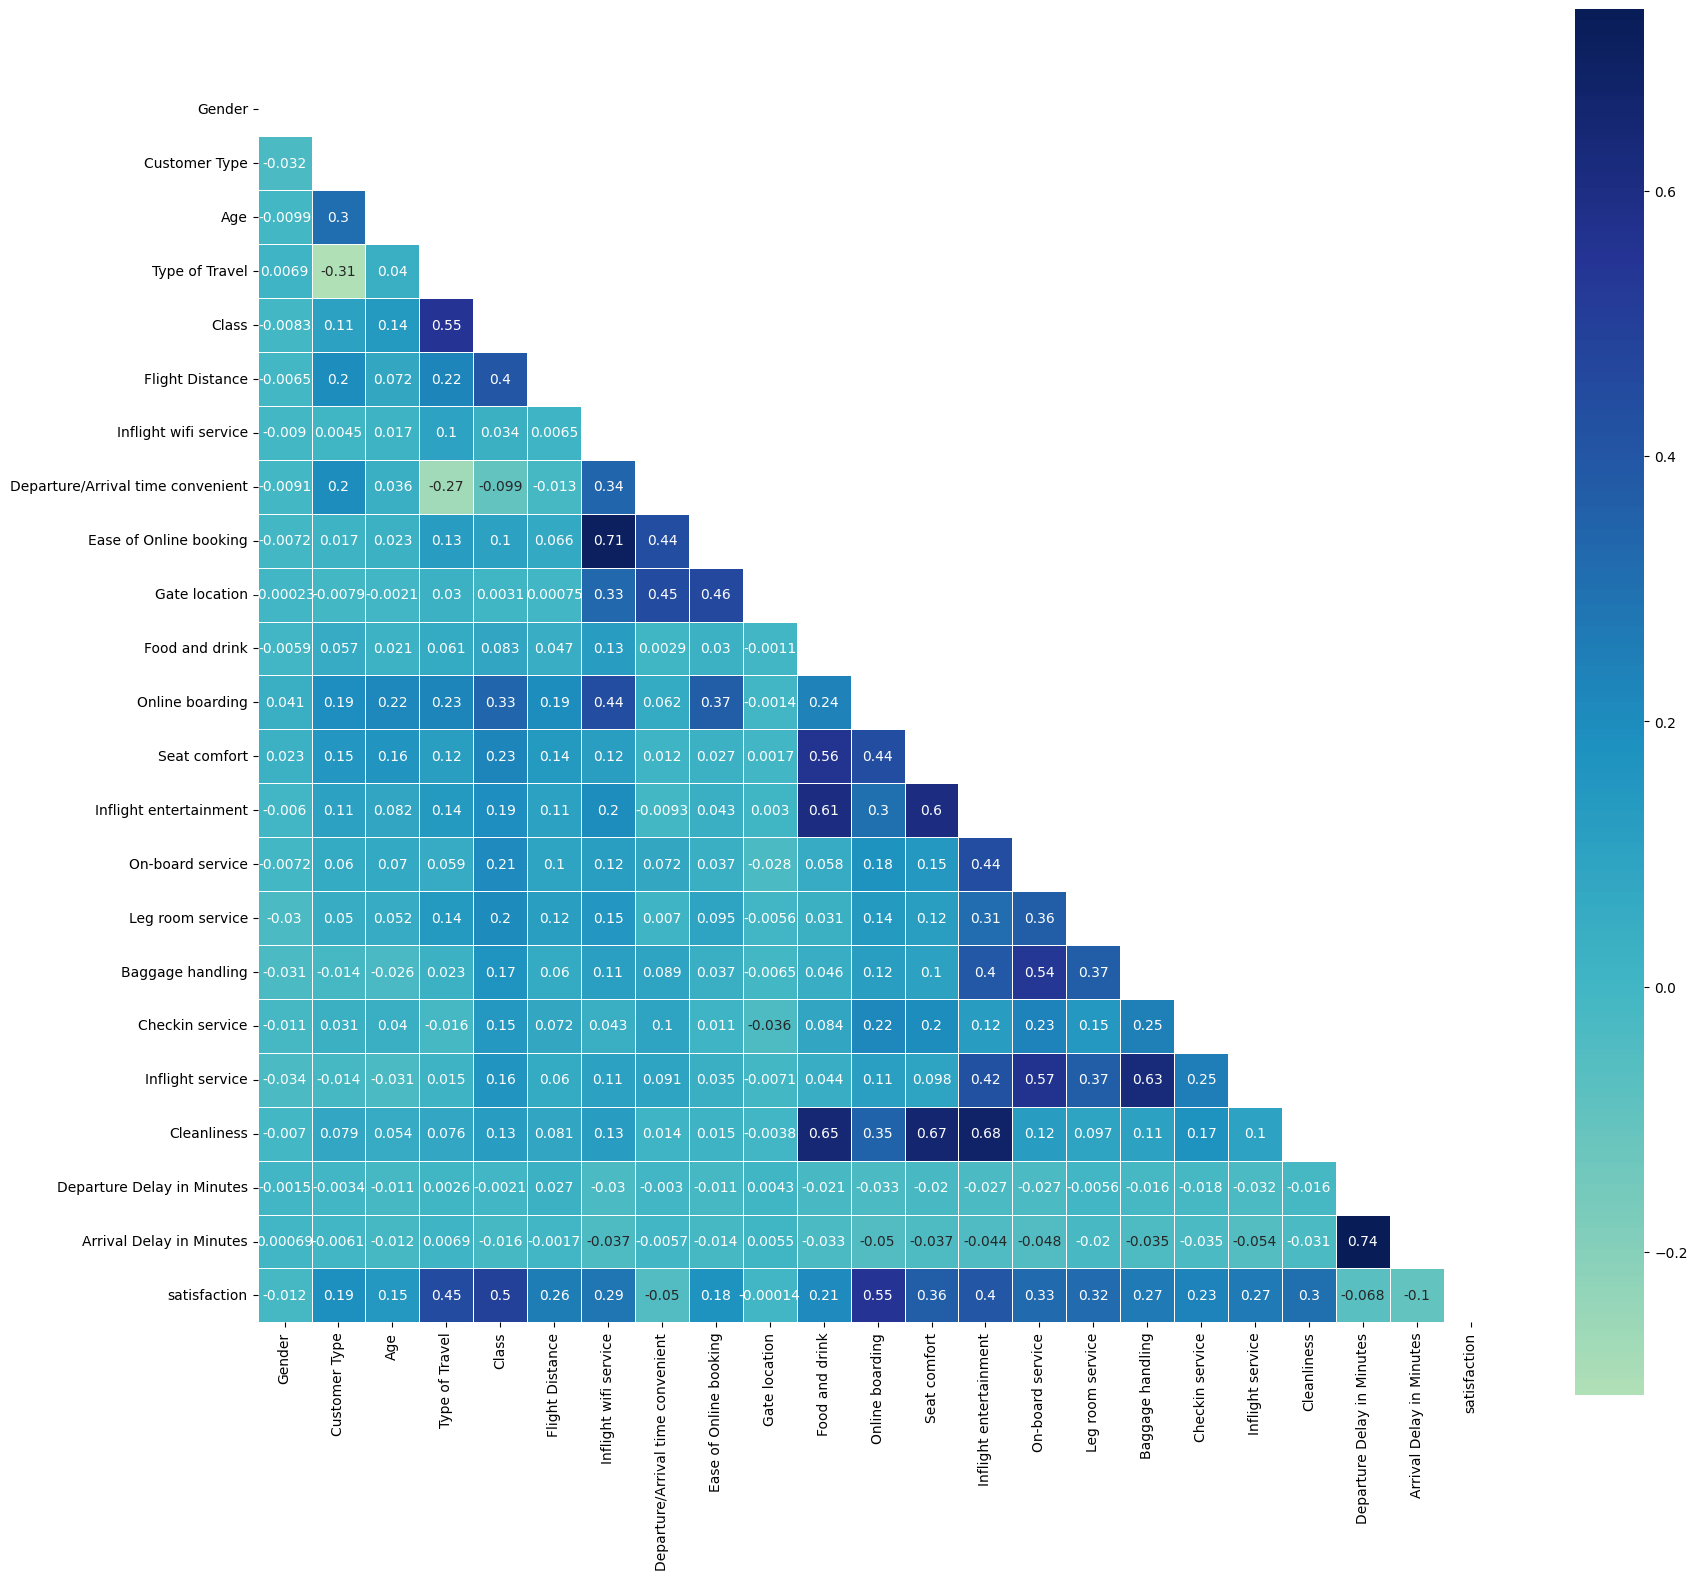

In [16]:
corr = train.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)

Model Evaluation

Now to the models! We will be trying out a few different models to see which one is the best choice for our problem. I have created a small function below which will train, predict, and evaluate all of our models. We will be evaluating performance of our models with the ROC_AUC metric.
This metric is good for classification of a dataset which a relatively balance dataset in terms of our target. We will also be looking at the confusion matrix for our model to best understand how our model is mischaracterizing predictions (Are we seeing majority false positives? etc.)



In [17]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, roc_auc

ROC_AUC = 0.9607290873474874
              precision    recall  f1-score   support

           0    0.95556   0.97969   0.96747     14573
           1    0.97318   0.94177   0.95722     11403

    accuracy                        0.96304     25976
   macro avg    0.96437   0.96073   0.96234     25976
weighted avg    0.96329   0.96304   0.96297     25976



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


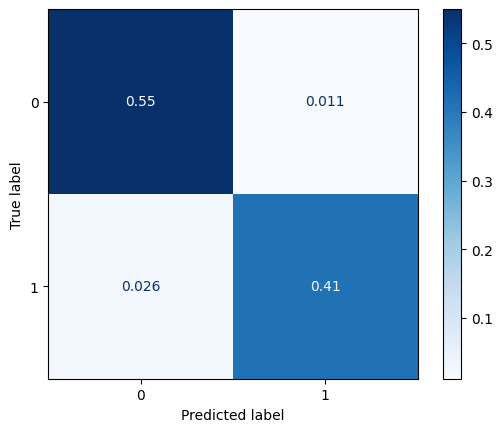

In [18]:
params_rf = {'max_depth': 25,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 1200,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

ROC_AUC = 0.9613126285764666
              precision    recall  f1-score   support

           0    0.95778   0.97770   0.96764     14573
           1    0.97072   0.94493   0.95765     11403

    accuracy                        0.96331     25976
   macro avg    0.96425   0.96131   0.96264     25976
weighted avg    0.96346   0.96331   0.96325     25976



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


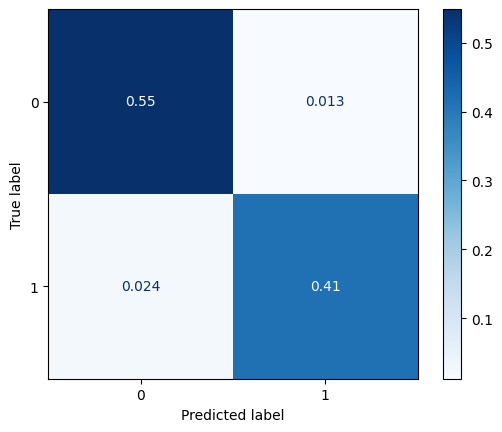

In [19]:
params_xgb ={}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

ROC_AUC = 0.8672686383639016
              precision    recall  f1-score   support

           0    0.87252   0.90318   0.88759     14573
           1    0.87044   0.83136   0.85045     11403

    accuracy                        0.87165     25976
   macro avg    0.87148   0.86727   0.86902     25976
weighted avg    0.87161   0.87165   0.87128     25976



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


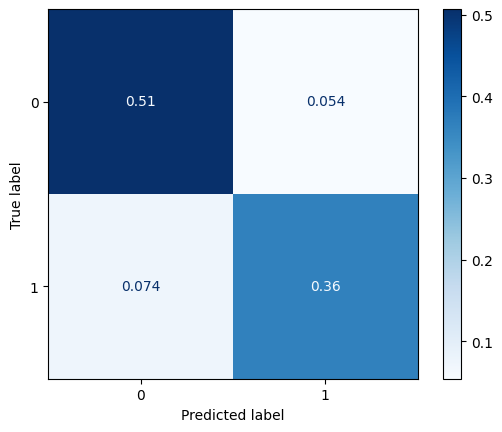

In [23]:
#Logistic Regression with Sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log = LogisticRegression()

log.fit(X_train,y_train)

pred = log.predict(X_test)

log, roc_auc_log= run_model(log, X_train, y_train, X_test, y_test)

ROC_AUC = 0.9466372049971934
              precision    recall  f1-score   support

           0    0.95436   0.95142   0.95289     14573
           1    0.93816   0.94186   0.94000     11403

    accuracy                        0.94722     25976
   macro avg    0.94626   0.94664   0.94645     25976
weighted avg    0.94725   0.94722   0.94723     25976



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


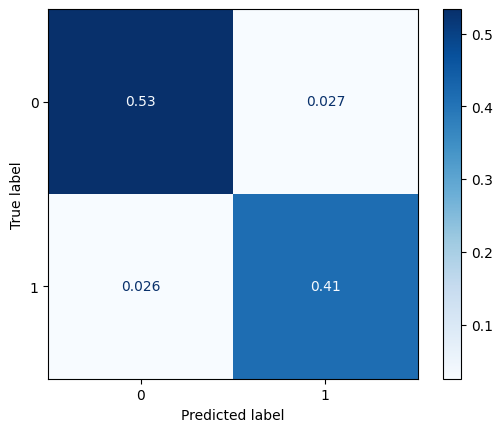

In [28]:
#Decision Tree:

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train,y_train)

dt, roc_auc_dt= run_model(dt, X_train, y_train, X_test, y_test)

In [30]:
results=pd.DataFrame({'Model':['Random Forest','XGB','Logistic Regression', 'Decision tree'],
                    'Accuracy Score':[roc_auc_rf,roc_auc_xgb,roc_auc_log,roc_auc_dt]})
result_df=results.sort_values(by='Accuracy Score', ascending=False)
result_df=result_df.set_index('Model')
result_df

,Accuracy Score
Model,
XGB,0.961313
Random Forest,0.960729
Decision tree,0.946637
Logistic Regression,0.867269


In [31]:
import pickle
import requests
import json

In [33]:
pickle.dump(model_xgb, open('model.pkl','wb'))

In [34]:
model = pickle.load(open('model.pkl','rb'))
print(model.predict([[1.8]]))

[1]
